### Homework 3: covariate shift and deep ensembles
CS-229 Spring 2023

In [164]:
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


class MyClassifier(t.nn.Module):
    """TODO: 2 points. Define your classifier. Note that my viz code below
    assumes outputs are logits."""
    def __init__(self, n_classes=2):
        super().__init__()

    def forward(self, x):

                              
class MyEnsemble(t.nn.Module):
    """TODO: 2 points, ensembled model
    This class implements an ensemble classifier from a list of models.
    Note that my viz code below assumes outputs are all logits. 
    """
    def __init__(self, models):
        super().__init__()
        self.models = models
        
    def forward(self, x):


# Load data and construct train dataloaders
x_train, y_train, x_val, y_val, x_test, y_test = t.load('hw3_data.pt')
print('dataset sizes: ', x_train.shape, x_val.shape, x_test.shape)
batch_size = 100
train_ds = t.utils.data.TensorDataset(x_train, y_train)
train_dl = t.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Create and train models
n_models = 10
models = []
for i in range(n_models):
    model = MyClassifier()
    
    # TODO: 2 points. Train each model on train_dl.
    
    models.append(model)  # store them for evaluation and ensembling
    
model_ens = MyEnsemble(models)  # Construct the ensemble model

dataset sizes:  torch.Size([2000, 2]) torch.Size([2000, 2]) torch.Size([1000, 2])


### Output the accuracy and expected calibration error, for the model and ensemble

In [165]:
def accuracy(model, x, y):
    # TODO: 1 point accuracy function 

def ece(model, x, y, bins=10): 
    # TODO: expected calibration error, 2 point

    
# TODO (1 point): run accuracy/ece on models/data to generate table.
# Don't forget to turn off grad tracking and use eval mode, 
# It's good practice even it doesn't make much difference here. 

# Feel free to use my code below that automatically outputs a nice table.
# Pandas can output latex tables too, very convenient. 

def vector_of_results(model):
    columns = ['Acc-train', 'Acc-val', 'Acc-test', 
               'ECE-train', 'ECE-val', 'ECE-test']
    results = t.zeros(6)
    results[0] = accuracy(model, x_train, y_train)
    results[1] = accuracy(model, x_val, y_val)
    results[2] = accuracy(model, x_test, y_test)
    results[3] = ece(model, x_train, y_train)
    results[4] = ece(model, x_val, y_val)
    results[5] = ece(model, x_test, y_test)
    return columns, results

with t.no_grad():
    results = t.zeros(6, 10)  # accuracy/ECE for train/val/test, then model index
    for i, model in enumerate(models):
        model.eval()  
        columns, results[:,i] = vector_of_results(model)
    results = results.mean(axis=1)
    
    columns, ens_results = vector_of_results(model_ens)


df = pd.DataFrame(data=[results.numpy(), ens_results.numpy()], index=['Mean of models', 'Ensemble model'], columns=columns)
precision = '{:.3f}'.format
print(df.to_string(float_format=precision))

                Acc-train  Acc-val  Acc-test  ECE-train  ECE-val  ECE-test
Mean of models      0.994    0.994     0.806      0.148    0.150     0.182
Ensemble model      0.994    0.994     0.817      0.148    0.151     0.174


### Visualize the results

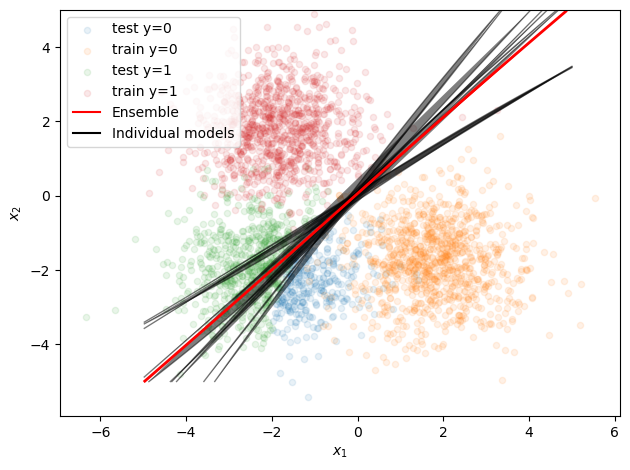

In [166]:
# Feel free to use my code or make your own. 

# viz datasets
fig, ax = plt.subplots()

for label in [0, 1]:
    ax.scatter(x_test[y_test==label, 0],x_test[y_test==label, 1], s=20, alpha=0.1, label='test y='+str(label))
    ax.scatter(x_train[y_train==label, 0],x_train[y_train==label, 1], s=20, alpha=0.1, label='train y='+str(label))

# Contour plot
k = 200
X = t.stack(t.meshgrid(t.linspace(-5, 5, k), t.linspace(-5, 5, k))).reshape((2, -1)).T
xx = X[:,0].reshape((k,k))
yy = X[:,1].reshape((k,k))

with t.no_grad():
    for i, model in enumerate(models):
        pred = t.softmax(model(X), axis=1)[:,0].numpy()
        zz = pred.reshape((k,k)).astype('float')
        contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=0.5)

        contour.collections[0].set_color('black')
        contour.collections[0].set_linewidth(1)
        # contour.collections[0].set_label('model '+str(i))
        
    pred = t.softmax(model_ens(X), axis=1)[:,0].numpy()
    zz = pred.reshape((k,k)).astype('float')
    contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=1)

    contour.collections[0].set_color('red')
    contour.collections[0].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
line = Line2D([0], [0], label='Ensemble', color='red')
line2 = Line2D([0], [0], label='Individual models', color='black')
# add manual symbols to auto legend
handles.extend([line, line2])
    
ax.legend(handles=handles, loc='upper left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()